# FRAUD MODELS TO CLASSIFY IF A TRANSACTION IS FRAUD OR NOT


## 1.  Import de librerías y dataset

In [292]:
# Importamos todas las librerias necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import os

# Instalar category_encoders si no se encuentra en el entorno
!pip install category_encoders -q
from category_encoders import WOEEncoder

# Para predicción y codificacion de variables
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, balanced_accuracy_score,
    confusion_matrix,precision_recall_curve, f1_score
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint, uniform, loguniform




In [232]:
# Desactivo notacion cientifica de numpy y pandas
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)


#### PARA CARGA LOCAL DEL DATASET - descomentar en caso de correrlo de forma local

In [233]:

# definimos el path para descargar el dataset
print(os.listdir())
file_path = os.getcwd()
file_path_data = f"{file_path}/financial_fraud_detection.csv"


['Examen Dataming Avanzado 2025_virtual.pdf', 'Code_clasificacion.ipynb', '.DS_Store', 'Code_clasificacion_v0.ipynb', 'nba_salaries.csv', 'Ejercicio_10_Examen_final_Data_Mining.ipynb', 'financial_fraud_detection.csv']


In [234]:

# guardamos el dataset en un dataframe
df = pd.read_csv(file_path_data)


#### FIN DE CARGA LOCAL DEL DATASET

#### INICIO DE CARGA DEL DATASET A COLAB

In [235]:
"""
from google.colab import drive
drive.mount("/content/drive")


os.listdir('/content/drive')
"""

'\nfrom google.colab import drive\ndrive.mount("/content/drive")\n\n\nos.listdir(\'/content/drive\')\n'

In [236]:
"""
TARGET_FILE = 'financial_fraud_detection.csv'

matches = []

for root, dirs, files in os.walk('/content/drive/MyDrive'):
    if TARGET_FILE in files:
        matches.append(os.path.join(root, TARGET_FILE))

matches

"""

"\nTARGET_FILE = 'financial_fraud_detection.csv'\n\nmatches = []\n\nfor root, dirs, files in os.walk('/content/drive/MyDrive'):\n    if TARGET_FILE in files:\n        matches.append(os.path.join(root, TARGET_FILE))\n\nmatches\n\n"

In [237]:
"""
file_path_data = "/content/drive/MyDrive/Colab Notebooks/financial_fraud_detection.csv"
df = pd.read_csv(file_path_data)
"""

'\nfile_path_data = "/content/drive/MyDrive/Colab Notebooks/financial_fraud_detection.csv"\ndf = pd.read_csv(file_path_data)\n'

### FIN PARA COLAB

In [238]:
# primeras 5 filas
print("Primeros 5 registros del dataset:")
display(df.head())

Primeros 5 registros del dataset:


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
0,T100000,2023-08-22T09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,False,NaN,NaN,-0.21,3,0.22,card,13.101.214.112,D8536477
1,T100001,2023-08-04T01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,False,NaN,NaN,-0.14,7,0.96,ACH,172.52.47.194,D2622631
2,T100002,2023-05-12T11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,False,NaN,NaN,-1.78,20,0.89,card,185.98.35.23,D4823498
3,T100003,2023-10-10T06:04:43.195112,ACC996865,ACC344098,1666.22,deposit,online,Sydney,pos,False,NaN,NaN,-0.60,6,0.37,wire_transfer,107.136.36.87,D9961380
4,T100004,2023-09-24T08:09:02.700162,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,False,NaN,NaN,0.79,13,0.27,ACH,108.161.108.255,D7637601


### Descripción del dataset


Este dataset es una simulación de transacciones financieras realizadas por usuarios en una plataforma digital. Fue diseñado para estudiar y modelar problemas de detección de fraude, reproduciendo patrones típicos de sistemas de pago reales, se obtuvo desde kaggle https://www.kaggle.com/datasets/aryan208/financial-transactions-dataset-for-fraud-detection

### Descripción de las columnas
- **transaction_id** : identificador único de cada transacción
- **timestamp**: fecha en la que ocurrió la transacción
- **sender_account**: id de quien inicia la transacción
- **receiver_account**: id del recipiente
- **amount**: monto en usd
- **transaction_type**: deposit, withdrawal, transfer, or payment
- **merchant_category:** tipo de comercio de la transacción
- **location**: lugar de donde ocurre la transacción
- **device_used**: tipo de dispositivo utilizado mobile, web, atm, pos
- **is_fraud**: valor booleano que indicia si la transacción fue fraudulenta o no. Este será el tag a predecir.
- **fraud_type**: tipo de fraude, viene null si no es fraude
- **time_since_last_transaction**: horas desde la transacción anterior
- **spending_deviation_score**: score que mide que tan extraña / desviada esta la transacción
- **velocity_score**: numero de transacciones en las ultimas horas previas
- **geo_anomaly_score**: mide que tan usual es la geolocalizacion de la transacción (score de 0 a 1)
- **payment_channel**: tipo de pago, card / wire_transfer / etc
- **ip_address**: punto de origen de la transacción
- **device_hash**: hash que representa un perfil único de cada dispositivo en base a ciertos patrones



In [239]:

# Debido a que varias de las columnas anteriores corresponden a otros modelos o tienen algun tipo de feature engineering,
# decidimos quitarlas del dataset para tomar el dataset aun mas crudo

cols_to_drop = [
    'spending_deviation_score',
    'velocity_score'
]

df = df.drop(columns=cols_to_drop, errors='ignore')


In [240]:
# cant filas y columnas
print("la cantidad de filas del dataset es de:",df.shape[0])
print("la cantidad de columnas del dataset es de:",df.shape[1])

la cantidad de filas del dataset es de: 5000000
la cantidad de columnas del dataset es de: 16


### DEBIDO A QUE ES UN DATASET MUY GRANDE DE 5 MILLONES DE REGISTROS, SE HARA UN SUBSTE PARA LOGRAR OBTENER RESULTADOS COHERENTES EN UN TIEMPO DE PROCESAMIENTO TAMBIEN COHERENTE
### SE HA TRATADO DE CORRER TODO EL DATASET ENTERO PERO NO SE LOGRÓ FINALIZAR DEBIDO A QUE SON 4 MODELOS CON OPTIMIZACION DE HIPERPARAMETROS
### TAMBIEN SE HA TRATADO CON SUBSET MAS GRANDE DE 500K Y 250K PERO TAMPOCO SE LOGRÓ CORRER, POR ESTO SE ELIGEN UN SUBSET DE 50K FILAS
### SE MANTIENE EL % DE FRAUDE EN EL NUEVO SUBSET DE 50K FILAS

In [241]:
SEED = 943153
N_TOTAL = 50000

df = (
    df.groupby('is_fraud', group_keys=False)
      .apply(lambda x: x.sample(
          n=max(1, int(N_TOTAL * len(x) / len(df))),
          random_state=SEED
      ))
      .reset_index(drop=True)
)

print(df.shape)
print("Fraud rate:", df['is_fraud'].mean())


/var/folders/9d/y864n_sx68vcszrqmyq053hh0000gn/T/ipykernel_4251/4145548967.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('is_fraud', group_keys=False)


(49999, 16)
Fraud rate: 0.03590071801436029


## 2. EDA

In [242]:
# tipo de datos de cada columna
print("Tipos de datos:")
print(df.dtypes)


Tipos de datos:
transaction_id                  object
timestamp                       object
sender_account                  object
receiver_account                object
amount                         float64
transaction_type                object
merchant_category               object
location                        object
device_used                     object
is_fraud                          bool
fraud_type                      object
time_since_last_transaction    float64
geo_anomaly_score              float64
payment_channel                 object
ip_address                      object
device_hash                     object
dtype: object


In [243]:

print("Tipos de datos:")
print(df.dtypes)

Tipos de datos:
transaction_id                  object
timestamp                       object
sender_account                  object
receiver_account                object
amount                         float64
transaction_type                object
merchant_category               object
location                        object
device_used                     object
is_fraud                          bool
fraud_type                      object
time_since_last_transaction    float64
geo_anomaly_score              float64
payment_channel                 object
ip_address                      object
device_hash                     object
dtype: object


### Valores nulos

In [244]:
# Porcentaje de valores nulos por columna
null_percentage = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print("Porcentaje de valores nulos:")
print(null_percentage)

Porcentaje de valores nulos:
fraud_type                    96.41
time_since_last_transaction   17.49
transaction_id                 0.00
timestamp                      0.00
sender_account                 0.00
receiver_account               0.00
amount                         0.00
transaction_type               0.00
merchant_category              0.00
location                       0.00
device_used                    0.00
is_fraud                       0.00
geo_anomaly_score              0.00
payment_channel                0.00
ip_address                     0.00
device_hash                    0.00
dtype: float64


### Fraud_type esta atado a nuestro clasificador y tiene mucho sentido que tenga un alto porcentaje de null dado que solamente un share muy pequeño de las transacciones son fraudulentas en la realdidad

### time_since_last_transaction podría también estar bien, suponiendo que ese sender_Account no tiene transacciones previas, podría venir null pero hay que chequearlo

In [245]:
# ordenamos para cada sender_account de forma ascendente por fecha de transacción
df = df.sort_values(['sender_account', 'timestamp'])

In [246]:
# genero un booleano que indica si es la primera transacción de ese user
df['is_first_tx'] = (df.groupby('sender_account').cumcount() == 0)

In [247]:
df = df.sort_values(['sender_account', 'timestamp'])

df['is_first_tx'] = (
    df.groupby('sender_account')
      .cumcount() == 0
)


In [248]:
# porcion del df con nulls correctos, es decir, aquellos con time_since_last_transaction null y is_first_tx is true
null_correctos = df[df['time_since_last_transaction'].isnull() & df['is_first_tx']== True]

# porcion del df con nulls incorrecots
null_incorrectos = df[df['time_since_last_transaction'].isnull() & (~df['is_first_tx'])]


In [249]:
total_nulls = df['time_since_last_transaction'].isna().sum()

print(f"Total NULLs: {total_nulls}")
print(f"NULLs correctos (primera tx): {len(null_correctos)}")
print(f"NULLs incorrectos (error): {len(null_incorrectos)}")
print(f"% de NULLs incorrectos: {len(null_incorrectos)/total_nulls}")


Total NULLs: 8745
NULLs correctos (primera tx): 8563
NULLs incorrectos (error): 182
% de NULLs incorrectos: 0.020811892510005717


In [250]:
# ya que efectivamente no tiene mucho sentido el cálculo de time_since_last_transaction, se procede a recalcularlo manualmente

# se elimina del df la columna
df = df.drop(columns='time_since_last_transaction')


In [251]:

# se parsea timestamp para poder hacer el calculo
df['timestamp_dt'] = pd.to_datetime(
    df['timestamp'],
    errors='coerce'
)

# ordenar
df = df.sort_values(['sender_account', 'timestamp_dt'])

# timestamp anterior
df['prev_timestamp'] = df.groupby('sender_account')['timestamp_dt'].shift(1)

# delta correcto (timedelta) en segundos
df['time_since_last_transaction'] = (
    df['timestamp_dt'] - df['prev_timestamp']
).dt.total_seconds()


In [252]:
# vuelvo a probar con los nulls
# Porcentaje de valores nulos por columna
null_percentage = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print("Porcentaje de valores nulos:")
print(null_percentage)

Porcentaje de valores nulos:
time_since_last_transaction   97.42
prev_timestamp                97.42
fraud_type                    96.41
timestamp_dt                   0.00
is_first_tx                    0.00
device_hash                    0.00
ip_address                     0.00
payment_channel                0.00
geo_anomaly_score              0.00
transaction_id                 0.00
timestamp                      0.00
device_used                    0.00
location                       0.00
merchant_category              0.00
transaction_type               0.00
amount                         0.00
receiver_account               0.00
sender_account                 0.00
is_fraud                       0.00
dtype: float64


In [253]:
# finalmente vuelvo a chequear que todos los nulls de time_since_last_transaction coincidan con la primera transaccion
# porcion del df con nulls correctos, es decir, aquellos con time_since_last_transaction null y is_first_tx is true
null_correctos = df[df['time_since_last_transaction'].isnull() & df['is_first_tx']== True]

# porcion del df con nulls incorrecots
null_incorrectos = df[df['time_since_last_transaction'].isnull() & (~df['is_first_tx'])]

total_nulls = df['time_since_last_transaction'].isna().sum()

print(f"Total NULLs: {total_nulls}")
print(f"NULLs correctos (primera tx): {len(null_correctos)}")
print(f"NULLs incorrectos (error): {len(null_incorrectos)}")
print(f"% de NULLs incorrectos: {len(null_incorrectos)/total_nulls}")


Total NULLs: 48707
NULLs correctos (primera tx): 48707
NULLs incorrectos (error): 0
% de NULLs incorrectos: 0.0


In [254]:
# creamos variables en minutos, horas y dias para que sea mas visual el numero
df['minutes_since_last_trx'] = df['time_since_last_transaction'] / 60
df['hs_since_last_trx'] = df['minutes_since_last_trx'] / 60
df['days_since_last_trx'] = df['hs_since_last_trx'] / 24

In [255]:
# cant filas y columnas
print("la cantidad de filas del dataset es de:",df.shape[0])
print("la cantidad de columnas del dataset es de:",df.shape[1])

la cantidad de filas del dataset es de: 49999
la cantidad de columnas del dataset es de: 22


In [256]:
# Distribución de variable objetivo
fraud_counts = df['is_fraud'].value_counts()
fraud_pct = df['is_fraud'].value_counts(normalize=True) * 100

print("Cantidad por clase:")
print(fraud_counts)
print("\nPorcentaje por clase:")
print(fraud_pct)


Cantidad por clase:
is_fraud
False    48204
True      1795
Name: count, dtype: int64

Porcentaje por clase:
is_fraud
False   96.41
True     3.59
Name: proportion, dtype: float64


In [257]:
# Resumen estadístico de las variables numéricas
print("Resumen estadístico:")
display(df.describe())

Resumen estadístico:


,amount,geo_anomaly_score,timestamp_dt,prev_timestamp,time_since_last_transaction,minutes_since_last_trx,hs_since_last_trx,days_since_last_trx
count,49999.00,49999.00,49999,1292,1292.00,1292.00,1292.00,1292.00
mean,361.28,0.50,2023-07-02 21:32:28.591659776,2023-05-06 07:45:17.736710144,10316803.68,171946.73,2865.78,119.41
min,0.01,0.00,2023-01-01 04:31:36.545132,2023-01-01 05:00:46.456125,33128.80,552.15,9.20,0.38
25%,27.12,0.25,2023-04-02 05:24:58.312560128,2023-02-18 23:24:50.165620992,4033945.62,67232.43,1120.54,46.69
50%,142.17,0.50,2023-07-02 22:26:26.108494080,2023-04-24 01:47:55.243743488,9527537.89,158792.30,2646.54,110.27
75%,510.27,0.75,2023-10-02 05:12:35.078190592,2023-07-08 14:48:25.795618304,15338696.92,255644.95,4260.75,177.53
max,2985.50,1.00,2024-01-01 21:09:55.920966,2023-12-29 00:34:33.644937,30675686.77,511261.45,8521.02,355.04
std,470.33,0.29,NaN,NaN,7297152.73,121619.21,2026.99,84.46


### Se puede observar que es un data set donde predominan las variables de montos altos, por lo general, las bases de datos transaccionales no suelen tener medias tan altas
### También, se logra observar que los usuarios tardan varias semanas en volver a transaccionar
### Contiene data desde Enero 2023 hasta Enero 2024

### Algunos numeros general para entender distribuciones

In [258]:
df.groupby('device_used')['device_used'].size()

device_used
atm       12465
mobile    12557
pos       12443
web       12534
Name: device_used, dtype: int64

In [259]:
# Ranking de senders con mas transacciones
df.groupby('sender_account')['transaction_id'].size().sort_values(ascending=False)


sender_account
ACC383518    4
ACC398119    3
ACC255943    3
ACC503005    3
ACC638421    3
            ..
ACC405439    1
ACC405448    1
ACC405467    1
ACC405486    1
ACC999987    1
Name: transaction_id, Length: 48707, dtype: int64

In [260]:
# Ranking de receivers con mas transacciones
df.groupby('receiver_account')['transaction_id'].size().sort_values(ascending=False)

receiver_account
ACC572956    3
ACC327039    3
ACC641539    3
ACC450826    3
ACC287321    3
            ..
ACC405423    1
ACC405476    1
ACC405478    1
ACC405482    1
ACC999983    1
Name: transaction_id, Length: 48674, dtype: int64

In [261]:
# observamos si hay pares que transaccionan mucho juntos
# asegurar orden temporal global
df = df.sort_values(['sender_account','receiver_account','timestamp_dt'])

df['pair_counts'] = (
    df.groupby(['sender_account','receiver_account'])
      .cumcount()          # 0 para primera vez que aparece ese par
)

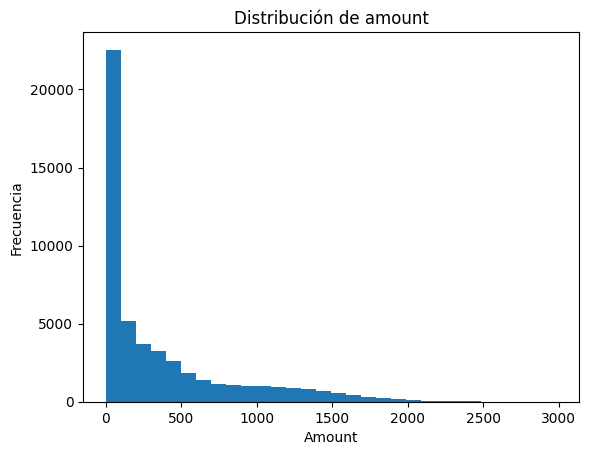

In [262]:
# distribución del amount
plt.hist(df['amount'], bins=30)
plt.xlabel('Amount')
plt.ylabel('Frecuencia')
plt.title('Distribución de amount')
plt.show()


<Axes: xlabel='date'>

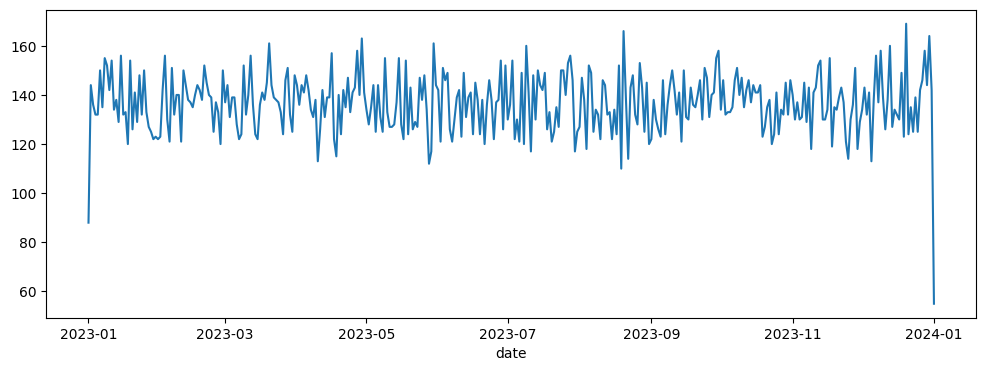

In [263]:
# permite observar si hay estacionalidad en la cantidad de transacciones
df['date'] = df['timestamp_dt'].dt.date

tx_per_day = df.groupby('date').size()

tx_per_day.plot(figsize=(12,4))


In [264]:
# comportamiento del amount con respecto al fraude
df.groupby('is_fraud')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
False,48204.00,361.11,470.15,0.01,27.11,142.03,509.50,2985.50
True,1795.00,365.83,475.38,0.01,27.38,145.54,524.91,2308.03


## 3. Feature Engineering

In [265]:
# creamos variable nueva que indica la cantida de transacciones que tienen entre pares de sender y receiver
df = df.sort_values(['sender_account', 'receiver_account', 'timestamp'])

df['pair_counts'] = (
    df.groupby(['sender_account', 'receiver_account'])
      .cumcount()
)


In [266]:
df['pair_counts'].describe()


count   49999.00
mean        0.00
std         0.00
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         0.00
Name: pair_counts, dtype: float64

In [267]:
# variable que suma el monto por parejas de sender y receiver
df['pair_amount'] = (
    df.groupby(['sender_account','receiver_account'])['amount']
      .cumsum()
      .shift(1)
      .fillna(0)
)

df['pair_amount'].describe()


count   49999.00
mean      361.26
std       470.32
min         0.00
25%        27.12
50%       142.13
75%       510.23
max      2985.50
Name: pair_amount, dtype: float64

In [268]:
# mide la cardinalidad de cada sender con resecto a los receivers, es decir, mide a cuanto receivers le envia cada sender
df['n_unique_receivers_sender'] = (
    df
    .groupby('sender_account')['receiver_account']
    .transform('nunique')
)


In [269]:
# edad del sender, tiempo entre su primera y ultima transacción
# Asegurar que timestamp_dt sea datetime
df["timestamp_dt"] = pd.to_datetime(df["timestamp_dt"], errors="coerce")


# EDAD del sender al momento de la transacción 
# sender_age_days = días desde la PRIMERA transacción del sender hasta esta transacción
sender_first = (
    df.groupby("sender_account")["timestamp_dt"]
      .transform("min")
)

df["sender_age_days"] = (df["timestamp_dt"] - sender_first).dt.total_seconds() / (60 * 60 * 24)
df["sender_age_days"] = df["sender_age_days"].fillna(0)  




# EDAD del receiver al momento de la transacción (causal, sin leakage)
# receiver_age_days = días desde la PRIMERA transacción del receiver hasta esta transacción

receiver_first = (
    df.groupby("receiver_account")["timestamp_dt"]
      .transform("min")
)

df["receiver_age_days"] = (df["timestamp_dt"] - receiver_first).dt.total_seconds() / (60 * 60 * 24)
df["receiver_age_days"] = df["receiver_age_days"].fillna(0)


In [270]:
#cantidad total de trx del sender
df['n_tx_sender'] = (
    df.groupby('sender_account')
      .cumcount()
)

In [271]:
# monto total del sender hasta el momento de la transaccion
df = df.sort_values(['sender_account', 'timestamp'])

df['amount_sum_sender'] = (
    df.groupby('sender_account')['amount']
      .cumsum()
      .shift(1)
      .fillna(0)
)


In [272]:
# monto promedio por transaccion del sender
df['amount_avg_sender'] = (
    df.groupby('sender_account')['amount']
      .expanding()
      .mean()
      .shift(1)
      .reset_index(level=0, drop=True)
      .fillna(0)
)



In [273]:
df = df.sort_values(['device_hash', 'timestamp'])
# cantidad de transacciones por device hash
df['qty_trx_device_hash'] = (
    df.groupby('device_hash')
      .cumcount()
)
# amount de transacciones por device hash
df['amt_trx_device_hash'] = (
    df.groupby('device_hash')['amount']
      .cumsum()
      .shift(1)
      .fillna(0)
)


## 4. Pipeline + Codificación de variables

In [274]:
# vemos las columnas categoricas con su respectivo tipo de dato
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
df[cat_cols].dtypes

transaction_id       object
timestamp            object
sender_account       object
receiver_account     object
transaction_type     object
merchant_category    object
location             object
device_used          object
fraud_type           object
payment_channel      object
ip_address           object
device_hash          object
date                 object
dtype: object

In [275]:
# cardinalidad de cada columna, sirve para entender la cantidad de datos unicos que hay en cada una y entender a cuales a aplicar woe o one hot encoder
# % de unicos en cada fila, para detectar variables con cardinalidad tan alta que pierde poder predictivo
(df.nunique() / len(df)) * 100
for col in cat_cols:
    print(col, (df[col].nunique() / len(df)) * 100,"---" ,df[col].nunique())

transaction_id 100.0 --- 49999
timestamp 100.0 --- 49999
sender_account 97.41594831896639 --- 48707
receiver_account 97.34994699893997 --- 48674
transaction_type 0.008000160003200064 --- 4
merchant_category 0.01600032000640013 --- 8
location 0.01600032000640013 --- 8
device_used 0.008000160003200064 --- 4
fraud_type 0.002000040000800016 --- 1
payment_channel 0.008000160003200064 --- 4
ip_address 100.0 --- 49999
device_hash 99.7039940798816 --- 49851
date 0.7320146402928058 --- 366


In [276]:
# Ya habiendo realizado todo el EDA, se comenzará a utilizar un nuevo df donde eliminaremos aquellas variables con muy alta cardinalidad y que no aportan al modelo
cols_to_drop = ['transaction_id','timestamp','sender_account','receiver_account','ip_address','device_hash','date', 'time_since_last_transaction','minutes_since_last_trx','hs_since_last_trx',]

df_eda = df.drop(columns=cols_to_drop, errors='ignore')
df_eda.head()



,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,geo_anomaly_score,payment_channel,is_first_tx,...,pair_counts,pair_amount,n_unique_receivers_sender,sender_age_days,receiver_age_days,n_tx_sender,amount_sum_sender,amount_avg_sender,qty_trx_device_hash,amt_trx_device_hash
34575,60.83,transfer,other,Singapore,pos,False,NaN,0.33,wire_transfer,True,...,0,209.99,1,0.00,0.00,0,209.99,209.99,0,0.00
12041,11.79,transfer,entertainment,Dubai,mobile,False,NaN,0.62,ACH,True,...,0,0.01,1,0.00,0.00,0,0.01,0.01,0,60.83
35864,355.45,deposit,other,Singapore,atm,False,NaN,0.67,wire_transfer,True,...,0,31.88,1,0.00,0.00,0,31.88,31.88,0,11.79
28594,633.48,withdrawal,travel,Dubai,web,False,NaN,0.37,ACH,True,...,0,20.98,1,0.00,0.00,0,20.98,20.98,0,355.45
27521,24.55,payment,other,Tokyo,web,False,NaN,0.05,ACH,True,...,0,445.15,1,0.00,0.00,0,445.15,445.15,0,633.48


In [277]:
# Seteo de columnas para transformar

target_col = 'is_fraud'

cols_to_woe = ['merchant_category', 'location']
cols_to_ohe = ['device_used', 'transaction_type', 'payment_channel']

# todas las numéricas y por las dudas dropea el target
numeric_cols = (
    df_eda.select_dtypes(include=['number'])
      .columns
      .drop([target_col], errors='ignore')
      .tolist()
)

# Defino X dataset con features e Y al target que deseamos predecir
feature_cols = numeric_cols + cols_to_woe + cols_to_ohe
X = df_eda[feature_cols].copy()
y = df_eda[target_col].astype(int)

# Preprocesamiento

# imputa la mediana a los nulls
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# codificamos variables woe
woe_pipe = Pipeline(steps=[
    ('woe', WOEEncoder(handle_unknown='value', handle_missing='value'))
])

# codificamos variables one hot encoder
ohe_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore')  # sparse por defecto
)
])

# transformamos las variables cada una con el metodo correspondiente
pre = ColumnTransformer(
    transformers=[
        ('num', num_pipe, numeric_cols),
        ('woe', woe_pipe, cols_to_woe),
        ('ohe', ohe_pipe, cols_to_ohe),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)


#### definimos parametros para grid search, el cual busca en base a un intervalo de valores para algunos parametros, cuales son los mejores. -- se utiliza grid search a fines practicos debido que se hacen 4 gridsearchs uno por cada modelo, por lo tanto, hay que reducir el costo computacional
#### sin embargo, utilizar random search es mejor y mas preciso, aunque al tener que iterarlo varias veces, puede hacer mas pesada la corrida

In [278]:
# Split Train/Test (hold-out) + CV en Train

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=943153,
    stratify=y
)

# K-fold sobre el 70% de train
cv = StratifiedKFold(
    n_splits=3, # 3 folds para reducir el costo computacional, lo ideal es que sea un numero mayor, capaz hasta cercano a 10
    shuffle=True,
    random_state=943153
)

# parametros para el grid search
## pocos hiperparam solo a fines practicos para reducir costo computacional y lograr que corra

param_grids = {

    "SVM_RBF": {
        "estimator": SVC(kernel="rbf", probability=True, random_state=943153),
        "param_grid": {
            "clf__C": [1, 10],
            "clf__gamma": ["scale", 0.1],
            "clf__class_weight": [None, "balanced"]
        }
    },

    "RandomForest": {
        "estimator": RandomForestClassifier(random_state=943153, n_jobs=-1),
        "param_grid": {
            "clf__n_estimators": [100, 150],
            "clf__max_depth": [None, 10]
        }
    },

    "GradientBoosting": {
        "estimator": GradientBoostingClassifier(random_state=943153),
        "param_grid": {
            "clf__n_estimators": [100, 200],
            "clf__learning_rate": [0.05, 0.1],
            "clf__max_depth": [2, 3]
        }
    },

    "MLP": {
        "estimator": MLPClassifier(random_state=943153, max_iter=200, early_stopping=True),
        "param_grid": {
            "clf__hidden_layer_sizes": [(50,), (100,)],
            "clf__alpha": [0.0001, 0.001]
        }
    }
}


In [279]:
# Train: gridsearch por modelo

best_searches = {}   # guardamos el objeto search
summary_rows = []    # para tabla comparativa final

for model_name, spec in param_grids.items():

    # preprocesamiento y modelo
    pipe = Pipeline(steps=[
        ('pre', pre),
        ('clf', spec['estimator'])
    ])

# grid search
    search = GridSearchCV(
        estimator=pipe,
        param_grid=spec["param_grid"],
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        verbose=2,
        refit=True
    )

    # Fit solo en train con los datos con subset
    search.fit(X_train, y_train)  


    # guardamos mejor search
    best_searches[model_name] = search

    # guardamos resumen de CV
    summary_rows.append({
        "model": model_name,
        "best_cv_roc_auc_tune": search.best_score_,
        "best_params": search.best_params_,
        "n_candidates": len(search.cv_results_["params"])
    })


results_df = pd.DataFrame(summary_rows).sort_values("best_cv_roc_auc_tune", ascending=False)
print(results_df[["model", "best_cv_roc_auc_tune", "n_candidates"]].to_string(index=False))


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[CV] END .clf__C=1, clf__class_weight=None, clf__gamma=scale; total time= 1.3min
[CV] END .clf__C=1, clf__class_weight=None, clf__gamma=scale; total time= 1.3min
[CV] END .clf__C=1, clf__class_weight=None, clf__gamma=scale; total time= 1.3min
[CV] END ...clf__C=1, clf__class_weight=None, clf__gamma=0.1; total time= 1.4min
[CV] END ...clf__C=1, clf__class_weight=None, clf__gamma=0.1; total time= 1.4min
[CV] END ...clf__C=1, clf__class_weight=None, clf__gamma=0.1; total time= 1.4min
[CV] END ..clf__C=10, clf__class_weight=None, clf__gamma=0.1; total time= 2.3min
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=scale; total time= 2.9min
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=scale; total time= 2.9min
[CV] END clf__C=10, clf__class_weight=None, clf__gamma=scale; total time= 3.0min
[CV] END clf__C=1, clf__class_weight=balanced, clf__gamma=0.1; total time= 4.4min
[CV] END clf__C=1, clf__class_weight=balanced, clf__gamma=scale; total time= 4.7min
[CV] END clf__C=1, clf__

## Comparación y evaluación final

In [295]:

THRESHOLD = 0.0323106338544963 # seteo el punto de corte para decir si es fraude o no fraude, arriba del corte es fraude, es baja la probabilidad que definimos para el corte porque el share de fraude es muy pequeño en el modelo tambien
rows = []

for model_name, search in best_searches.items():
    best_pipe = search.best_estimator_

    # Probabilidades y predicción
    y_proba = best_pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= THRESHOLD).astype(int)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    rows.append({
        "model": model_name,

        # CV
        "cv_best_roc_auc": search.best_score_,  # es el roc auc sobre el conjunto de train en el cross validation

        # Test 
        "test_roc_auc": roc_auc_score(y_test, y_proba), # es el roc auc sobre el conjunto de test
        "test_pr_auc": average_precision_score(y_test, y_proba), # metrica conjunta de precision-recall

        # Test 
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "accuracy": accuracy_score(y_test, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),

        # Conteos útiles
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn

    })

compare_df = (
    pd.DataFrame(rows)
      .sort_values(["test_roc_auc", "recall"], ascending=False)
      .reset_index(drop=True)
)

compare_df


,model,cv_best_roc_auc,test_roc_auc,test_pr_auc,precision,recall,f1,accuracy,balanced_accuracy,tp,fp,fn,tn
0,GradientBoosting,0.50,0.51,0.04,0.04,0.90,0.07,0.17,0.52,483,12357,56,2104
1,SVM_RBF,0.51,0.51,0.04,0.04,0.96,0.07,0.08,0.50,518,13853,21,608
2,MLP,0.49,0.49,0.04,0.04,0.58,0.07,0.42,0.50,312,8448,227,6013
3,RandomForest,0.49,0.48,0.04,0.03,0.53,0.06,0.43,0.47,283,8348,256,6113


### Se logra concluir que lo modelos no tienen el suficiente poder predictivo, debido a su bajo roc-auc, y a los bajos valores en precision y recall, es un dataset muy desbalanceado el cual tiene solo un 3% de casos positivos. Sin embargo, se puede concluir que Gradient Boosting y SVM son los dos mejores modelos debido a que tienen los valores mas altos de roc auc. 
### Para poder decir que son buenos modelos, deberiamos tener alguno con una precision arriba de 80% (cantidad de veces que no se equivoca al detectar positivos) y un recall minimamente arriba del 70% (cantidad de casos positivos que detecta), estos valores depende mas de reglas de negocio por lo que pueden cambiar. Estos valores dependen del punto de corte elegido, que en este caso está en 0.1, el cual es bastante bajo justamente porque todo arriba de 0.1 es considerado fraude, y la proporción de fraude en el dataset es muy baja.
### A continuación se buscan las variables mas importantes del Gradient Boosting y se buscará el mejor punto de corte.


### IMPORTANCIA DE VARIABLES

In [ ]:

# Tomo el mejor pipeline
rf_pipe = best_searches["GradientBoosting"].best_estimator_

#  Extraigo el modelo entrenado
rf_model = rf_pipe.named_steps["clf"]

#  Nombres de features ya transformadas por el preprocesador
# (incluye numéricas + woe + one-hot)
feature_names = rf_pipe.named_steps["pre"].get_feature_names_out()

#  Feature importance
imp = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

imp.head(30)


,feature,importance
0,amount,0.20
2,days_since_last_trx,0.19
12,amt_trx_device_hash,0.11
10,amount_avg_sender,0.09
7,receiver_age_days,0.08
6,sender_age_days,0.08
4,pair_amount,0.08
9,amount_sum_sender,0.05
13,merchant_category,0.03
1,geo_anomaly_score,0.03


#### MEJORES CORTES EN BASE A 

In [296]:
# Elegir un punto de corte (threshold) para convertir probabilidades en clase 0/1
# maximizando F1 (equilibrio entre precision y recall)

# Tomamos el mejor pipeline encontrado por GridSearchCV para GradientBoosting.
best_model = best_searches["GradientBoosting"].best_estimator_

# Calculamos probabilidades de la clase positiva para cada fila de X_test.

y_proba = best_model.predict_proba(X_test)[:, 1]

# Calculamos la curva Precision-Recall variando el threshold.
#    Devuelve:
#    - prec: precisión para cada punto de la curva
#    - rec:  recall para cada punto de la curva
#    - thresholds: lista de thresholds usados
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

# Calculamos F1 para cada punto de la curva:
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)

# Buscamos el índice del mejor F1 (donde F1 es máximo).
best_idx = np.argmax(f1_scores)

# Extraemos el threshold y las métricas asociadas a ese punto "óptimo".
thr_idx = min(best_idx, len(thresholds) - 1)

best_threshold = thresholds[thr_idx]
best_f1 = f1_scores[best_idx]
best_precision = prec[best_idx]
best_recall = rec[best_idx]

# Mostramos resultados
print("best_threshold:", best_threshold)
print("best_f1:", best_f1)
print("best_precision:", best_precision)
print("best_recall:", best_recall)


best_threshold: 0.0323106338544963
best_f1: 0.072202705655537
best_precision: 0.03761682242990654
best_recall: 0.8961038961038961


#### EL MEJOR CORTE ESTA EN 0.032 EL CUAL MAXIMIZA F1 SCORE DANDO UNA PRECISION MUY BAJA DE 0.037 Y UN RECALL CERCANO A 0.9. ESTOS RESULTADOS NO SON OPTIMOS DADO QUE EL MODELO ESTARIA PREDICIENDO EL 90% DE LOS FRAUDES PERO EQUIVOCANDOSE EN (1-PRECISION) DE LAS VECES QUE PREDICE QUE UNA TRANSACCION ES FRAUDULENTA, GENERANDO UNA ELEVADA CANTIDAD DE FALSOS POSITIVOS.